## Nate Finck

Changes made: 

* reduced epochs on the training to 10 because it was taking very long to run

* reduced batch size on the training also because it was taking very long to run

* On the pieces model, I changed the metrics to 'accuracy' because I wanted to see how well the model was performing. 

# **Libraries Loading**

In [98]:
import chess
import os 
import pandas as pd 
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random

# **Dataset Reading**

1. Uploading the chess_game.csv if its not exist on drive.
2. Number of chess games from dataset used for training algorithm.

In [24]:
from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [25]:
indice = 2000 # number of chess games used in training out of available in dataset.
df = pd.read_csv('/content/chess_game-1.csv')
data = df['moves'].tolist()[:indice]

# **Dataset Preprocessing**

1. Extracting single game all moves keys from dataset.
2. Dividing single game moves into steps
3. Using chess library extracting board state from move.
4. Defining training matrix from individual moves.
5. Translating matrix stages positions to arrays for model training
6. Making labels from arrays for training  

In [26]:
split_data = []
for point in data[:indice]:
    point = point.split()
    split_data.append(point)

In [27]:
data = []
for game in split_data:
    board = chess.Board()
    for move in game:
        board_ready = board.copy()
        data.append(board.copy())
        board.push_san(move)

In [28]:
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
alpha_dict = {
    'a' : [0,0,0,0,0,0,0],
    'b' : [1,0,0,0,0,0,0],
    'c' : [0,1,0,0,0,0,0],
    'd' : [0,0,1,0,0,0,0],
    'e' : [0,0,0,1,0,0,0],
    'f' : [0,0,0,0,1,0,0],
    'g' : [0,0,0,0,0,1,0],
    'h' : [0,0,0,0,0,0,1],
}
number_dict = {
    1 : [0,0,0,0,0,0,0],
    2 : [1,0,0,0,0,0,0],
    3 : [0,1,0,0,0,0,0],
    4 : [0,0,1,0,0,0,0],
    5 : [0,0,0,1,0,0,0],
    6 : [0,0,0,0,1,0,0],
    7 : [0,0,0,0,0,1,0],
    8 : [0,0,0,0,0,0,1],
}

In [29]:
def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo

def translate(matrix,chess_dict):

    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

def flatten(l): 
    return [item for sublist in l for item in sublist]

trans_data = []
for board in data:
    matrix = make_matrix(board)
    trans = translate(matrix,chess_dict)
    trans_data.append(trans)

pieces = []
alphas = []
numbers = []

true_data = flatten(split_data)

for i in range(len(true_data)):
    try:
        term = true_data[i]
        original = term[:]
        term = term.replace('x','')
        term = term.replace('#','')
        term = term.replace('+','')
        if len(term) == 2:
            piece = 'p' 
        else:
            piece = term[0]
        alpha = term[-2]
        number = term[-1]
        pieces.append(chess_dict[piece])
        alphas.append(alpha_dict[alpha])
        numbers.append(number_dict[int(number)])
    except:
        pass
print("Transformed data")

Transformed data


# **Model Building**

Defining 3 models for prediction of pieces, Alpha and Numbers predictions.



In [148]:
def createModelPiece():
    board_inputs = keras.Input(shape=(8, 8, 12))
    conv1 = layers.Conv2D(10, 3, activation='relu')
    conv2 = layers.Conv2D(10, 3, activation='relu')
    pooling1 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    pooling2 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    flatten = keras.layers.Flatten(data_format=None)
    x = conv1(board_inputs)
    x = pooling1(x)
    x = conv2(x)
    x = flatten(x)
    piece_output = layers.Dense(12, name='piece')(x)
    model_pieces = keras.Model(
        inputs=board_inputs, outputs=piece_output, name="chess_ai_v3")
    
    model_pieces.compile(
        loss=keras.losses.mse,
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy'],
    )
    
    return model_pieces
def createModelAlpha():
    board_inputs = keras.Input(shape=(8, 8, 12))
    conv1 = layers.Conv2D(10, 3, activation='relu')
    conv2 = layers.Conv2D(10, 3, activation='relu')
    pooling1 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    pooling2 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    flatten = keras.layers.Flatten(data_format=None)
    x = conv1(board_inputs)
    x = pooling1(x)
    x = conv2(x)
    x = flatten(x)
    alpha_output = layers.Dense(7, name='alpha')(x)
    model_alpha = keras.Model(
        inputs=board_inputs, outputs=alpha_output, name="chess_ai_v3")
    
    model_alpha.compile(
        loss=keras.losses.mse,
        optimizer=keras.optimizers.Adam(),
        metrics=None,)
    
    return model_alpha


def createModelNumber():
    board_inputs = keras.Input(shape=(8, 8, 12))
    conv1 = layers.Conv2D(10, 3, activation='relu')
    conv2 = layers.Conv2D(10, 3, activation='relu')
    pooling1 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    pooling2 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    flatten = keras.layers.Flatten(data_format=None)
    x = conv1(board_inputs)
    x = pooling1(x)
    x = conv2(x)
    x = flatten(x)
    numbers_output = layers.Dense(7, name='number')(x)
    model_number = keras.Model(
        inputs=board_inputs, outputs=numbers_output, name="chess_ai_v3")
    model_number.compile(
        loss=keras.losses.mse,
        optimizer=keras.optimizers.Adam(),
        metrics=None,
    )
    
    return model_number

# **Models Training**

1. Using earling stop to stop the training when model not coverging
2. Train all the models if save model not found
3. Save the model


In [31]:
# dont know when the model will stop converging, so we use early stopping to reduce the number of cycles when the loss is no longer changing
earlystop = keras.callbacks.EarlyStopping(
        monitor='loss', min_delta=0, patience=250, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

In [150]:
print("Loading model_pieces")
if os.path.exists("model_pieces\\"):
    model_pieces = keras.models.load_model("model_pieces")
else:
    model_pieces = createModelPiece()
print("Loaded model_pieces")
model_pieces.fit(trans_data[:len(pieces)],
                 pieces[:len(pieces)], batch_size=32, epochs=5,verbose=2, callbacks=[earlystop])
model_pieces.save("model_pieces")
print("Saved model_pieces")

Loading model_pieces
Loaded model_pieces


KeyboardInterrupt: ignored

In [33]:
print("Loading model_alpha (columns)")
if os.path.exists("model_alpha\\"):
    model_alpha = keras.models.load_model("model_alpha")
else:
    model_alpha = createModelAlpha()
print("Loaded model_alpha (columns)")

model_alpha.fit(trans_data[:len(alphas)], alphas[:len(alphas)], batch_size=32, epochs=5,verbose=2, callbacks=[earlystop])
model_alpha.save("model_alpha")
print("Saved model_alpha (columns)")

Loading model_alpha (columns)
Loaded model_alpha (columns)
Epoch 1/5
3393/3393 - 111s - loss: 0.1144 - 111s/epoch - 33ms/step
Epoch 2/5
3393/3393 - 112s - loss: 0.1138 - 112s/epoch - 33ms/step
Epoch 3/5
3393/3393 - 102s - loss: 0.1138 - 102s/epoch - 30ms/step
Epoch 4/5
3393/3393 - 90s - loss: 0.1138 - 90s/epoch - 27ms/step
Epoch 5/5
3393/3393 - 91s - loss: 0.1137 - 91s/epoch - 27ms/step
INFO:tensorflow:Assets written to: model_alpha/assets
Saved model_alpha (columns)


In [34]:
print("Loading model_number (rows)")
if os.path.exists("model_number\\"):
    model_number = keras.models.load_model("model_number")
else:
    model_number = createModelNumber()
print("Loaded model_number (rows)")

model_number.fit(trans_data[:len(numbers)], numbers[:len(numbers)], batch_size=32, epochs=5,verbose=2, callbacks=[earlystop])
model_number.save("model_number")
print("Saved model_number (rows)")

Loading model_number (rows)
Loaded model_number (rows)
Epoch 1/5
3393/3393 - 179s - loss: 0.1145 - 179s/epoch - 53ms/step
Epoch 2/5
3393/3393 - 143s - loss: 0.1137 - 143s/epoch - 42ms/step
Epoch 3/5
3393/3393 - 140s - loss: 0.1137 - 140s/epoch - 41ms/step
Epoch 4/5
3393/3393 - 142s - loss: 0.1137 - 142s/epoch - 42ms/step
Epoch 5/5
3393/3393 - 170s - loss: 0.1136 - 170s/epoch - 50ms/step
INFO:tensorflow:Assets written to: model_number/assets
Saved model_number (rows)


# **Chess stage Prediction**


In [35]:
new_chess_dict = {}
new_alpha_dict = {}
new_number_dict = {}
for term in chess_dict:
    definition = tuple(chess_dict[term])
    new_chess_dict[definition] = term
    new_chess_dict[term] = definition

for term in alpha_dict:
    definition = tuple(alpha_dict[term])
    new_alpha_dict[definition] = term
    new_alpha_dict[term] = definition

for term in number_dict:
    definition = tuple(number_dict[term])
    new_number_dict[definition] = term
    new_number_dict[term] = definition

In [88]:
def translate_pred(pred):
    translation = np.zeros(pred.shape)
    index = pred[0].tolist().index(max(pred[0]))
    translation[0][index] = 1
    return translation[0]

data = np.reshape(trans_data[0], (1, 8, 8, 12))
piece = translate_pred(model_pieces.predict(data))
alpha = translate_pred(model_alpha.predict(data))
number = translate_pred(model_alpha.predict(data))
piece_pred = new_chess_dict[tuple(piece)]
alpha_pred = new_alpha_dict[tuple(alpha)]
number_pred = new_number_dict[tuple(number)]
move = str(piece_pred)+str(alpha_pred)+str(number_pred)

if move[0]=='p':
  move=move[1:]
else:
  move= move

print(move)

p
d4


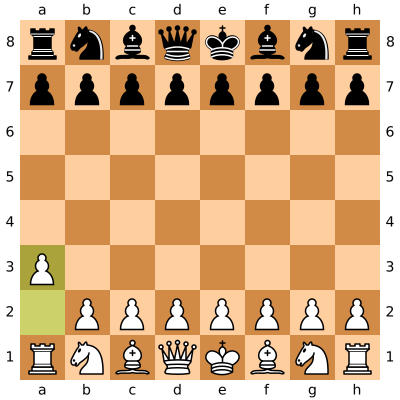

In [84]:
board = chess.Board()
board.push_san('a3')
# board.push_san(move)
board

First Step Board Initilization

In [106]:
def Move_prediction(board):
  matrix = make_matrix(board)
  trans = translate(matrix,chess_dict)


  data = np.reshape(trans, (1, 8, 8, 12))
  piece = translate_pred(model_pieces.predict(data))
  alpha = translate_pred(model_alpha.predict(data))
  number = translate_pred(model_alpha.predict(data))
  piece_pred = new_chess_dict[tuple(piece)]
  alpha_pred = new_alpha_dict[tuple(alpha)]
  number_pred = new_number_dict[tuple(number)]
  move = str(piece_pred)+str(alpha_pred)+str(number_pred)

  if move[0]=='p':
    move=move[1:]
  else:
    move= move
  return move

['a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1', 'a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2', 'a3', 'b3', 'c3', 'd3', 'e3', 'f3', 'g3', 'h3', 'a4', 'b4', 'c4', 'd4', 'e4', 'f4', 'g4', 'h4', 'a5', 'b5', 'c5', 'd5', 'e5', 'f5', 'g5', 'h5', 'a6', 'b6', 'c6', 'd6', 'e6', 'f6', 'g6', 'h6', 'a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7', 'a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8']
f3f7
Random stage move prediction


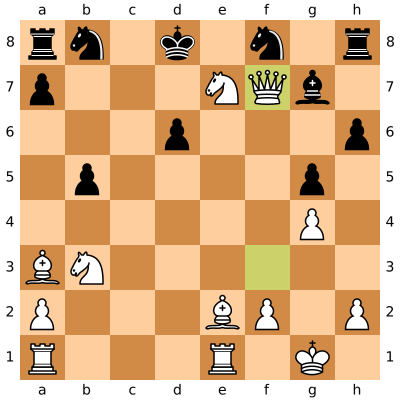

In [147]:
try:
  move=Move_prediction(board)
  board.push_san(move)
  print('Deep learning Move prediction')
except:
  All_possible_moves=list(board.legal_moves)
  Starting_move=All_possible_moves[random.randint(0,len(All_possible_moves)-1)]
  board.push(Starting_move)
  print(chess.SQUARE_NAMES)
  # print('1' in str(board.attackers(color=chess.WHITE, square=chess.SQUARE_NAMES))
  print(Starting_move)
  print('Random stage move prediction')
board